In this hackathon, the goal is to create a machine learning model that extracts entity values from images. This capability is crucial in fields like healthcare, e-commerce, and content moderation, where precise product information is vital. As digital marketplaces expand, many products lack detailed textual descriptions, making it essential to obtain key details directly from images. These images provide important information such as weight, volume, voltage, wattage, dimensions, and many more, which are critical for digital stores.

### Basic library imports

In [ ]:
import re
import constants
import os
import requests
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
import numpy as np
from pathlib import Path
from functools import partial
import requests
import urllib
from PIL import Image

### Read Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import requests
import concurrent.futures
import os

def download_image(image_url, save_path):
    try:
        response = requests.get(image_url, stream=True, timeout=10) # Stream for memory efficiency, timeout for robustness
        response.raise_for_status()  # Check for HTTP errors

        with open(save_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192): # Chunked download for memory efficiency
                f.write(chunk)

        print(f"Downloaded: {image_url}")
    except (requests.exceptions.RequestException, OSError) as e:
        print(f"Error downloading {image_url}: {e}")

def download_images_from_csv(csv_file, image_column, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    df = pd.read_csv(csv_file)  # Read CSV lazily if possible, use 'chunksize' if needed for very large files

    with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor: # Utilize multiple cores for faster downloads
        futures = []
        for image_url in df[image_column]:
            image_filename = image_url.split('/')[-1]  # Extract filename from URL
            save_path = os.path.join(save_directory, image_filename)
            futures.append(executor.submit(download_image, image_url, save_path))

        concurrent.futures.wait(futures)  # Wait for all downloads to complete


csv_file = '/content/drive/MyDrive/amazon/test.csv'
image_column = 'image_link'  # Replace with the actual column name in your CSV
save_directory = '/content/drive/MyDrive/amazon/downloaded_images'

download_images_from_csv(csv_file, image_column, save_directory)

## Sample PaddleOCR Result


In [ ]:
!pip install paddleocr

In [ ]:
!pip install paddlepaddle

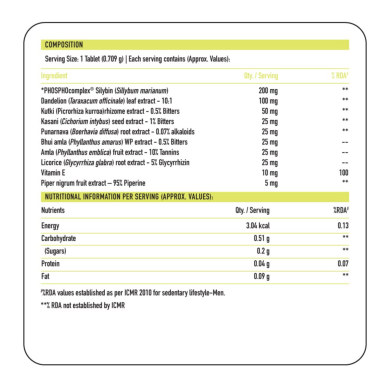

In [16]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = '/content/drive/MyDrive/amazon/test_1.jpg'


img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


In [14]:
from paddleocr import PaddleOCR, draw_ocr
import cv2
from PIL import Image
from PIL import ImageFont
import paddle
# Initialize the PaddleOCR model with the DBNet detector
# paddle.device.set_device('gpu')
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# Perform OCR on an image
img_path = '/content/drive/MyDrive/amazon/test_1.jpg'
result = ocr.ocr(img_path, cls=True)

# print the results
for idx in range(len(result)):
    res = result[idx]
    for line in res:
        print(line[1][0])
        print("")

[2024/09/26 18:07:44] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

# Ocr result df processing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/amazon/ocr_result.csv')

In [ ]:
df

,index,group_id,entity_name,image_names,answers
0,0,156839,height,110EibNyclL.jpg,"['91.44cm - 199.39cm', '36in - 78in', 'Cit', '..."
1,1,792578,width,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
2,2,792578,height,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
3,3,792578,depth,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
4,4,792578,depth,11gHj8dhhrL.jpg,"['90cm/35.43""', '10.50cm/4.13""', 'One Size', '..."
...,...,...,...,...,...
131182,131283,721522,maximum_weight_recommendation,A1rVsIzEtkL.jpg,"['1,500 LB weight capacity', 'FOREMAN']"
131183,131284,603688,item_weight,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA..."
131184,131285,603688,maximum_weight_recommendation,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA..."
131185,131286,853009,item_weight,A1tnTUPyr7L.jpg,"['noULn', '(955）123-4567', 'VICT02', 'NPAGL', ..."


# Regex for pattern matching and extracting dimension value with measuremnt units

In [ ]:
import re

def extract_data(text,key):
    def generate_regex_pattern(key):
        unit_values = {
        "item_weight": "mg, milligram, milligrams, g, gm, gms, gram, grams, kg, kgs, kilogram, kilograms, lb, lbs, pound, pounds, oz, ounce, ug, microgram, micrograms, ton, tons",
        "height": "m, meter, meters, cm, centimeter, centimeters, ft, foot, feet, in, inch, inches, cms, mm, millimeter, millimeters, yd, yard, yards",
        "depth": "m, meter, meters, cm, centimeter, centimeters, ft, foot, feet, in, inch, inches, cms, mm, millimeter, millimeters, yd, yard, yards, cubic foot, microlitre, cup, fluid ounce, centilitre, imperial gallon, pint, decilitre, litre, millilitre, quart, cubic inch, gallon",
        "item_volume": " l, liter, litres, ml, milliliter, milliliters, gal, gallon, gallons, fl oz, floz",
        "maximum_weight_recommendation": "mg, milligram, milligrams, g, gm, gms, gram, grams, kg, kgs, kilogram, kilograms, lb, lbs, pound, pounds, oz, ounce, ug, microgram, micrograms, ton, tons",
        "width": "m, meter, meters, cm, centimeter, centimeters, ft, foot, feet, in, inch, inches, cms, mm, millimeter, millimeters, yd, yard, yards",
        "voltage": "v, volt, volts, kv, kilovolt, kilovolts, mv, millivolt, millivolts",
        "wattage": "w, watt, watts, kw, kilowatts, killowatt"
        }
        """Generates a regex pattern for the given key from unit_values."""

        if key not in unit_values:
            raise ValueError(f"Invalid key: {key}. Available keys are: {list(unit_values.keys())}")

        units = unit_values[key].split(',')
        units_pattern = '|'.join([rf"{unit.strip()}" for unit in units])
        return rf".+?(\d+(\.\d+)?|\d+,\d+)\s*({units_pattern})"


    single_number_unit_pattern = generate_regex_pattern(key)
    cleaned_data = []
    matches = re.findall(single_number_unit_pattern, text)
    return matches

In [ ]:
import pandas as pd

# Define your function
def combine_characters_to_sentence(char_list):
    return ''.join(char_list)

# Apply the function to each row of the 'answers' column
df['combined_sentence'] = df['answers'].apply(combine_characters_to_sentence)

In [ ]:
df

,index,group_id,entity_name,image_names,answers,combined_sentence
0,0,156839,height,110EibNyclL.jpg,"['91.44cm - 199.39cm', '36in - 78in', 'Cit', '...","['91.44cm - 199.39cm', '36in - 78in', 'Cit', '..."
1,1,792578,width,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
2,2,792578,height,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
3,3,792578,depth,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'One Size', 'L..."
4,4,792578,depth,11gHj8dhhrL.jpg,"['90cm/35.43""', '10.50cm/4.13""', 'One Size', '...","['90cm/35.43""', '10.50cm/4.13""', 'One Size', '..."
...,...,...,...,...,...,...
131182,131283,721522,maximum_weight_recommendation,A1rVsIzEtkL.jpg,"['1,500 LB weight capacity', 'FOREMAN']","['1,500 LB weight capacity', 'FOREMAN']"
131183,131284,603688,item_weight,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA...","['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA..."
131184,131285,603688,maximum_weight_recommendation,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA...","['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA..."
131185,131286,853009,item_weight,A1tnTUPyr7L.jpg,"['noULn', '(955）123-4567', 'VICT02', 'NPAGL', ...","['noULn', '(955）123-4567', 'VICT02', 'NPAGL', ..."


In [ ]:
def apply_function_to_rows_with_entity_name(df, function, sentence_column, entity_name_column, result_column_name, error_value=None):
  def apply_with_error_handling(row):
    try:
      sentence = row[sentence_column]
      entity_name = row[entity_name_column]
      return function(sentence.lower(), entity_name)
    except Exception as e:
      print(f"Error processing row: {e}")
      return error_value

  df[result_column_name] = df.apply(apply_with_error_handling, axis=1)
  return df


df['combined_sentence'] = df['combined_sentence'].str.lower()
result_df = apply_function_to_rows_with_entity_name(df, extract_data, 'combined_sentence', 'entity_name', 'extracted_data_1')

In [ ]:
def process_extracted_data(data):
  if isinstance(data, list):
    result_string = ",".join(",".join(tup) for tup in data)
    return result_string
  else:
    return ""

result_df['processed_extracted_data'] = result_df['extracted_data_1'].apply(process_extracted_data)

Extracting highest value that is followed by measurement units

In [ ]:
def extract_highest_value_and_first_unit(text):
    """
    Extracts the highest numerical value and the first unit that appears after it in the text.

    Args:
        text: A string containing comma-separated values and units.

    Returns:
        A tuple containing the highest numerical value and the first unit found after it,
        or (None, None) if no valid values or units are found.
    """
    highest_value = None
    first_unit = None
    # Split the text into individual values
    text = re.sub(r'(\d+),(\d+)', r'\1\2', text)
    values = text.split(',')

    # Initialize variables to store the highest value and its unit


    # Iterate through the values
    for i in range(0, len(values)):
        try:
            # Check if the current value is numeric
            current_value = float(values[i])

            # Update the highest value if necessary
            if highest_value is None or current_value > highest_value:
                highest_value = current_value

                # Look for the first unit after the highest value
                for j in range(i + 1, len(values)):
                    if values[j] in ["mg", "milligram", "milligrams", "g", "gm", "gms", "gram", "grams", "kg", "kgs", "kilogram", "kilograms", "lb", "lbs", "pound", "pounds", "oz", "ounce", "ug", "microgram", "micrograms", "ton", "tons", "m", "meter", "meters", "cm", "centimeter", "centimeters", "ft", "foot", "feet", "in", "inch", "inches", "cms", "mm", "millimeter", "millimeters", "yd", "yard", "yards", "cubic foot", "microlitre", "cup", "fluid ounce", "centilitre", "imperial gallon", "pint", "decilitre", "litre", "millilitre", "quart", "cubic inch", "gallon", "l", "liter", "litres", "ml", "milliliter", "milliliters", "gal", "gallon", "gallons", "fl oz", "floz", "v", "volt", "volts", "kv", "kilovolt", "kilovolts", "mv", "millivolt", "millivolts", "w", "watt", "watts", "kw", "kilowatts", "killowatt"]:  # Add more units if needed
                        first_unit = values[j]
                        break  # Stop searching once a unit is found

        except ValueError:
            # Ignore values that cannot be converted to numbers
            pass

    return highest_value, first_unit

# Example usage
text = "91.44,.44,cm,199.39,.39,cm,36,,in,78,,in,2.63,.63,in"
highest_value, first_unit = extract_highest_value_and_first_unit(text)
print(f"Highest value: {highest_value}, First unit: {first_unit}")

Highest value: 199.39, First unit: cm


In [ ]:
result_df["text"] = result_df['processed_extracted_data'].apply(extract_highest_value_and_first_unit)

Formatting measurement as per submission requirement

In [ ]:
def format_measurement(value, unit, unit_conversion_map):
  """
  Formats a measurement with a given value and unit, using a unit conversion map.

  Args:
      value: A float representing the measurement value.
      unit: A string representing the measurement unit.
      unit_conversion_map: A dictionary mapping short unit names to their full names.

  Returns:
      A string representing the formatted measurement, or None if the unit is invalid.
  """

  # Check if the unit is valid
  if unit not in unit_conversion_map:
      return None

  # Convert the unit to its full name
  full_unit = unit_conversion_map[unit]

  # Format the measurement
  formatted_measurement = f"{value} {full_unit}"

  return formatted_measurement
result_df['text']
# Example usage
value = result_df['text'][0][0]
unit = result_df['text'][0][1]
unit_conversion_map = {
    'cm': 'centimetre',
    'cms': 'centimetre', # Added
    'ft': 'foot',
    'in': 'inch',
    'm': 'metre',
    'mm': 'millimetre',
    'yd': 'yard',
    'g': 'gram',
    'gm': 'gram', # Added
    'gms': 'gram', # Added
    'kg': 'kilogram',
    'kgs': 'kilogram', # Added
    'ug': 'microgram',
    'mg': 'milligram',
    'oz': 'ounce',
    'lb': 'pound',
    'lbs': 'pound', # Added
    'ton': 'ton',
    'tons': 'ton', # Added
    'kv': 'kilovolt',
    'mv': 'millivolt',
    'v': 'volt',
    'volts': 'volt', # Added
    'w': 'watt',
    'watts': 'watt', # Added
    'kw': 'kilowatt',
    'kilowatts': 'kilowatt', # Added
    'killowatt': 'kilowatt', # Added
    'cl': 'centilitre',
    'cu_ft': 'cubic foot',
    'cu_in': 'cubic inch',
    'cup': 'cup',
    'dl': 'decilitre',
    'fl_oz': 'fluid ounce',
    'floz': 'fluid ounce', # Added
    'gal': 'gallon',
    'imp_gal': 'imperial gallon',
    'l': 'litre',
    'litres': 'litre', # Added
    'liter': 'litre', # Added
    'ul': 'microlitre',
    'ml': 'millilitre',
    'milliliters': 'millilitre', # Added
    'milliliter': 'millilitre', # Added,
    'centimeters': 'centimetre',
    'feet': 'foot',
    'inches': 'inch',
    'meters': 'metre',
    'millimeters': 'millimetre',
    'yards': 'yard',
    'grams': 'gram',
    'kilograms': 'kilogram',
    'micrograms': 'microgram',
    'milligrams': 'milligram',
    'pounds': 'pound',
    'tons': 'ton',
    'kilovolts': 'kilovolt',
    'millivolts': 'millivolt',
    'gallon': 'gallon',
    'gallons': 'gallon'}

formatted_measurement = format_measurement(value, unit, unit_conversion_map)
print(formatted_measurement)  # Output: 199.39 centimetre

199.39 centimetre


In [ ]:
def apply_format_measurement(row):
  """Applies the format_measurement function to a row of the DataFrame."""
  value = row['text'][0]
  unit = row['text'][1]
  if value is not None and unit is not None:
    return format_measurement(value, unit, unit_conversion_map)
  else:
    return None

# Apply the function to the 'text' column
result_df['formatted_measurement_1'] = result_df.apply(apply_format_measurement, axis=1).fillna('')


In [ ]:
result_df

,index,group_id,entity_name,image_names,answers,combined_sentence,extracted_data_1,processed_extracted_data,text,formatted_measurement_1,extracted_data_2
0,0,156839,height,110EibNyclL.jpg,"['91.44cm - 199.39cm', '36in - 78in', 'Cit', '...","['91.44cm - 199.39cm', '36in - 78in', 'cit', '...","[(91.44, .44, cm), (199.39, .39, cm), (36, , i...","91.44,.44,cm,199.39,.39,cm,36,,in,78,,in,2.63,...","(199.39, cm)",199.39 centimetre,"[('91.44', '.44', 'cm'), ('199.39', '.39', 'cm..."
1,1,792578,width,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'one size', 'l...","[(200, , cm), (42, , cm)]","200,,cm,42,,cm","(200.0, cm)",200.0 centimetre,"[('200', '', 'cm'), ('42', '', 'cm')]"
2,2,792578,height,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'one size', 'l...","[(200, , cm), (42, , cm)]","200,,cm,42,,cm","(200.0, cm)",200.0 centimetre,"[('200', '', 'cm'), ('42', '', 'cm')]"
3,3,792578,depth,11TU2clswzL.jpg,"['200cm/78.74""', '42cm/16.54""', 'One Size', 'L...","['200cm/78.74""', '42cm/16.54""', 'one size', 'l...","[(200, , cm), (42, , cm)]","200,,cm,42,,cm","(200.0, cm)",200.0 centimetre,"[('200', '', 'cm'), ('42', '', 'cm')]"
4,4,792578,depth,11gHj8dhhrL.jpg,"['90cm/35.43""', '10.50cm/4.13""', 'One Size', '...","['90cm/35.43""', '10.50cm/4.13""', 'one size', '...","[(90, , cm), (10.50, .50, cm)]","90,,cm,10.50,.50,cm","(90.0, cm)",90.0 centimetre,"[('90', '', 'cm'), ('10.50', '.50', 'cm')]"
...,...,...,...,...,...,...,...,...,...,...,...
131182,131283,721522,maximum_weight_recommendation,A1rVsIzEtkL.jpg,"['1,500 LB weight capacity', 'FOREMAN']","['1,500 lb weight capacity', 'foreman']","[(1,500, , lb)]","1,500,,lb","(1500.0, lb)",1500.0 pound,"[('1,500', '', 'lb')]"
131183,131284,603688,item_weight,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA...","['themgreattubesforkids!', 'safetyandmaneuvera...",[],,"(None, None)",,[]
131184,131285,603688,maximum_weight_recommendation,A1rdvZ5zDdL.jpg,"['THEMGREATTUBESFORKIDS!', 'SAFETYANDMANEUVERA...","['themgreattubesforkids!', 'safetyandmaneuvera...",[],,"(None, None)",,[]
131185,131286,853009,item_weight,A1tnTUPyr7L.jpg,"['noULn', '(955）123-4567', 'VICT02', 'NPAGL', ...","['nouln', '(955）123-4567', 'vict02', 'npagl', ...",[],,"(None, None)",,[]


Predictions

In [ ]:
new_df = pd.DataFrame()
new_df['index'] = result_df['index']
new_df['prediction'] = result_df['formatted_measurement_1']
new_df.to_csv('output.csv', index=False)

In [ ]:
new_df

,index,prediction
0,0,199.39 centimetre
1,1,200.0 centimetre
2,2,200.0 centimetre
3,3,200.0 centimetre
4,4,90.0 centimetre
...,...,...
131182,131283,1500.0 pound
131183,131284,NaN
131184,131285,NaN
131185,131286,NaN


In [ ]:
non_nan_counts = new_df.notna().sum()
print(non_nan_counts)


index         131187
prediction    106941
dtype: int64
